# The Language of LLMs

Large Language Models like ChatGPT have rapidly become ubiquitous tools that enhance productivity, creativity, and even decision-making processes across various domains. Their ability to generate human-like text, comprehend complex instructions, and provide informative responses has captivated the imagination of users worldwide. This paragraph was generated by an LLM (and edited by me).

This workshop is for those that are curious as to how these models *interpret* the input. By the end of this hour, you will hopefully be able to answer the following questions, among others:

- How do Large Language Models *read* and process text?
- Why are LLMs good at complex tasks, but seem to perform poorly on seemingly simple tasks like spelling or arithmetic?
- How does an LLM understand what it is processing?

# Tokenization

Tokenization is the process of transforming a sequence of characters into a sequence of tokens. A token is a unit of text that we treat as a single entity. For example, in English, a token could be a word, a sentence, or a paragraph. In programming languages, a token could be a variable name, a keyword, or a string.

Let's begin with a *prompt* akin to one we might have used before.

In [ ]:
prompt = """
Why does my code 💥 with a segmentation fault?

#include "hash_map_utils.h"

int hash_function(char *key) {
    int hash = 0;

    for (int i = 0; i < strlen(key); i++) {
        hash += key[i];
    }

    return hash;
}

int compute_index(char *key, int map_size) {
    int hash = hash_function(key);
    int index = hash % map_size;

    return index;
}

double compute_load_factor(int num_keys, int bucket_size) {
    return (double)num_keys / bucket_size;
}

/*
 * Initializes the map to a given `size`.
 */
void init_map(hash_map_t *map, int size) {
    map->primary = calloc(size, sizeof(void *));
    map->map_size = size;
}

/*
 * Searches a map that implements incremental rehashing.
 * It is necessary to check both the old and new maps
 * when searching for a key.
 *
 * Returns NULL if no such key was found.
 */
hash_element_t *search(hash_map_t *map, char *key) {
    if (map->temp != NULL) {
        int index = compute_index(key, map->temp_size);
        hash_element_t *elem = map->temp[index];
        if (elem && !strcmp(elem->key, key)) {
            return elem;
        }
    }

    if (map->primary != NULL) {
        int index = compute_index(key, map->map_size);
        hash_element_t *elem = map->primary[index];
        if (!elem) {
            return NULL;
        }
        if (!strcmp(elem->key, key)) {
            return elem;
        }
    }

    return NULL;
}

/*
 * Performs incremental rehashing on the map.
 */
void rehash_inc(hash_map_t *map) {
    for (int i = 0; i < R_VALUE; i++) {
        // If there is nothing to rehash at the moment, return immediately.
        if (map->temp == NULL) {
            return;
        }

        // Iterate to next non-null value
        while (map->temp[map->temp_index] == NULL && map->temp_index < map->temp_size) {
            map->temp_index++;
        }

        // Check if temp map is empty
        if (map->temp_index == map->temp_size) {
            free(map->temp);
            map->temp = NULL;
            map->temp_index = 0;

            return;
        }

        hash_element_t *elem = map->temp[map->temp_index];
        int index = compute_index(elem->key, map->map_size);

        // Collision resolution via linear probing
        if (map->primary[index]) {
            printf("Rehashing collision detected!\n");

            while (map->primary[index] != NULL) {
                index = (index + 1) % map->map_size;
            }
        }

        map->primary[index] = elem;

        printf("Rehashing %s into %d\n", elem->key, index);

        map->temp[map->temp_index] = NULL;
    }
}

/*
 * Assumes that the element does not currently exist.
 */
void insert(hash_map_t *map, hash_element_t *elem) {
    double factor = compute_load_factor(map->num_keys + 1, map->map_size);

    printf("[DEBUG] factor = %.2lf\n", factor);

    if (factor >= LOAD_FACTOR) {
        printf("Beginning rehash...\n");
        // Begin rehash
        map->temp = map->primary;
        map->temp_size = map->map_size;
        map->primary = calloc(map->map_size * 2, sizeof(void *));
        map->map_size *= 2;
    }

    int index = compute_index(elem->key, map->map_size);

    if (map->primary[index]) {
        printf("Collision detected!\n");

        while (map->primary[index] != NULL) {
            index = (index + 1) % map->map_size;
        }
    }

    printf("Inserting %s at %d\n", elem->key, index);

    map->primary[index] = elem;
    map->num_keys++;

    rehash_inc(map);
}

/*
 * Assumes that the element does not currently exist.
 */
void insert_no_rehash(hash_map_t *map, hash_element_t *elem) {
    int index = compute_index(elem->key, map->map_size);

    if (map->primary[index]) {
        printf("Collision detected!\n");

        while (map->primary[index] != NULL) {
            index = (index + 1) % map->map_size;
        }
    }

    printf("Inserting %s at %d\n", elem->key, index);

    map->primary[index] = elem;
    map->num_keys++;
}
"""

**At the most basic level, how is this text represented in a computer?**

These characters are represented as encodings such as ASCII or Unicode. For the purposes of the rest of this article, we will assume the input is represented using Unicode.


In [ ]:
[ord(x) for x in prompt[:20]]

[10,
 87,
 104,
 121,
 32,
 100,
 111,
 101,
 115,
 32,
 109,
 121,
 32,
 99,
 111,
 100,
 101,
 32,
 128165,
 32]

Most of the values displayed in the previous cell are the same for ASCII. The emoji value has a very large number and can easily be spotted in the list.

The values you see above are the **Unicode code points** of the original input. These are not necessarily byte-level values. We can convert the original Unicode code points into byte-level values by encoding as `UTF-8`, `UTF-16`, or `UTF-32`. Let's try converting to `UTF-8`.

In [ ]:
list(prompt[:20].encode('utf-8'))

[10,
 87,
 104,
 121,
 32,
 100,
 111,
 101,
 115,
 32,
 109,
 121,
 32,
 99,
 111,
 100,
 101,
 32,
 240,
 159,
 146,
 165,
 32]

Notice how the emoji character is now represented by four consecutive bytes `240, 159, 146, 165`.

**Is that it? Is this how the input is fed into the model?**

This encoding is done at the character-level. What other types of encodings are there?

- Character encoding
- Word encoding
- Sub-word encoding

**What is the difference between them? Why would we pick one over another?**

In [ ]:
# Compute the length of our input as well as the tokenized version of it
input_length = len(prompt)
print(f"Input length: {input_length}")
tokens = prompt.encode("utf-8")
tokens = list(map(int, tokens))
token_length = len(tokens)
print(f"Token length: {token_length}")

Input length: 3947
Token length: 3950


# Byte Pair Encoding (BPE)

Byte Pair Encoding is a sub-word encoding technique that was originally designed for data compression. It is a simple algorithm that iteratively merges the most frequent pair of bytes in a sequence. This process is repeated until a predefined vocabulary size is reached.

Given a list of tokens, the following function will count the frequency of each pair and then sort them in descending order.

In [ ]:
def compute_pair_histogram(ids):
    """Iterate through pairs of 2 tokens at a time and count their frequency."""
    hist = {}

    for pair in zip(ids, ids[1:]):
        hist[pair] = hist.get(pair, 0) + 1

    return hist

pair_hist = compute_pair_histogram(tokens)
print(pair_hist)
print(sorted(((v, k) for k, v in pair_hist.items()), reverse=True))

{(10, 87): 1, (87, 104): 1, (104, 121): 1, (121, 32): 9, (32, 100): 7, (100, 111): 6, (111, 101): 3, (101, 115): 9, (115, 32): 19, (32, 109): 41, (109, 121): 1, (32, 99): 16, (99, 111): 10, (111, 100): 1, (100, 101): 45, (101, 32): 20, (32, 240): 1, (240, 159): 1, (159, 146): 1, (146, 165): 1, (165, 32): 1, (32, 119): 7, (119, 105): 1, (105, 116): 3, (116, 104): 13, (104, 32): 8, (32, 97): 8, (97, 32): 5, (32, 115): 8, (115, 101): 7, (101, 103): 3, (103, 109): 1, (109, 101): 16, (101, 110): 18, (110, 116): 40, (116, 97): 3, (97, 116): 9, (116, 105): 8, (105, 111): 8, (111, 110): 10, (110, 32): 18, (32, 102): 9, (102, 97): 7, (97, 117): 1, (117, 108): 2, (108, 116): 1, (116, 63): 1, (63, 10): 1, (10, 10): 35, (10, 35): 1, (35, 105): 1, (105, 110): 86, (110, 99): 7, (99, 108): 1, (108, 117): 3, (117, 100): 1, (32, 34): 1, (34, 104): 1, (104, 97): 35, (97, 115): 30, (115, 104): 29, (104, 95): 16, (95, 109): 7, (109, 97): 95, (97, 112): 81, (112, 95): 31, (95, 117): 1, (117, 116): 10, (105

A token of a double space appears 551 times in our original input. This should be surprising since there are so many spaces used when formatting the code.

## Creating new tokens

With the pairs identified, the merge operation will create a new token as a combination of the pair. This will only add a new token. The old tokens will remain as part of the vocabulary.

In [ ]:
def merge(ids, pair, idx):
    """Replaces occurrences of the pair with a new token."""
    newids = []
    i = 0
    while i < len(ids):
        if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
            newids.append(idx)
            i += 2
        else:
            newids.append(ids[i])
            i += 1
    return newids

vocab_size = 512
num_merges = vocab_size - 256 # Keep the initial ASCII tokens
ids = list(tokens)

merges = {}
for i in range(num_merges):
    pair_hist = compute_pair_histogram(ids)
    pair = max(pair_hist, key=pair_hist.get)
    idx = 256 + i
    print(f"merging {pair} into a new token {idx}")
    ids = merge(ids, pair, idx)
    merges[pair] = idx

merging (32, 32) into a new token 256
merging (256, 256) into a new token 257
merging (109, 97) into a new token 258
merging (10, 257) into a new token 259
merging (105, 110) into a new token 260
merging (258, 112) into a new token 261
merging (45, 62) into a new token 262
merging (259, 257) into a new token 263
merging (101, 109) into a new token 264
merging (261, 262) into a new token 265
merging (100, 101) into a new token 266
merging (61, 32) into a new token 267
merging (260, 266) into a new token 268
merging (268, 120) into a new token 269
merging (116, 32) into a new token 270
merging (104, 97) into a new token 271
merging (115, 105) into a new token 272
merging (271, 115) into a new token 273
merging (273, 104) into a new token 274
merging (32, 267) into a new token 275
merging (108, 264) into a new token 276
merging (41, 32) into a new token 277
merging (101, 276) into a new token 278
merging (107, 101) into a new token 279
merging (122, 101) into a new token 280
merging (272,

In [ ]:
print("tokens length:", len(tokens))
print("ids length:", len(ids))
print(f"compression ratio: {len(tokens) / len(ids):.2f}X")
len(merges)

tokens length: 3950
ids length: 798
compression ratio: 4.95X


256

## Constructing the vocabulary

Now that we have a list of unique tokens, we can construct the vocabulary. The first 256 tokens represent the standard 256 ASCII tokens. After that, we loop through the new tokens that were previously created and add them to `vocab`.

In [ ]:
vocab = {idx: bytes([idx]) for idx in range(256)}
for (p0, p1), idx in merges.items():
    vocab[idx] = vocab[p0] + vocab[p1]

def decode(ids):
    tokens = b"".join(vocab[idx] for idx in ids)
    text = tokens.decode("utf-8", errors="replace")

    return text

def encode(text):
    # given a string, return list of integers (the tokens)
    tokens = list(text.encode("utf-8"))
    while len(tokens) >= 2:
        pair_hist = compute_pair_histogram(tokens)
        pair = min(pair_hist, key=lambda p: merges.get(p, float("inf")))

        if pair not in merges:
            break

        idx = merges[pair]
        tokens = merge(tokens, pair, idx)

    return tokens

In [ ]:
print(len(encode(prompt)))

798


**What happens if we encounter tokens that were not part of our original vocabulary?**

Since we included basic characters in our vocabulary, we will be able to encode them, albeit inefficiently. For any tokens that are not in our vocabulary, we could map them to a special `UNKNOWN` token.

# Embeddings

A word embedding is a learned representation of text in which semantically similar words are mapped to nearby points in the embedding space. Since they are represented as vectors, all vector operations can be applied to them. This allows for the model to learn relationships between words and phrases, quantify their similarities and differences, and encode higher-level context information.

Embeddings can be learned independently or jointly with the model. For example, the Word2Vec model learns embeddings using an unsupervised approach. It predicts the context of a word given its surrounding words. The embeddings are then used as input to a downstream task (Mikolov et al., 2013).

LLMs typically train embeddings jointly with the model. This allows them to learn embeddings for sentences, paragraphs, or even whole documents.

## Creating an embedding layer

We can use libraries such as PyTorch to create a learnable embedding layer. The code below creates an embedding layer that converts each individual token into a `1024` dimensional embedded layer.

In [ ]:
import torch.nn as nn
import torch

token_embedding = nn.Embedding(vocab_size, 1024)
prompt_embedded = token_embedding(torch.LongTensor(encode(prompt)))
print(prompt_embedded.shape)

torch.Size([8, 1024])


## Training the embeddings

Our simple corpus of a single C file is far too simple to learn anything meaningful. Learning an embedding space requires a lot data and compute power.

# Sentence Embeddings

To demonstrate the power of embeddings, we will close out the workshop by reviewing sentence embeddings. BERT (Devlin et al., 2018) and RoBERTa (Liu et al., 2019) are LLMs that perform tasks such as semantic textual similarity. They both require that whole sentences be input, resulting in a very expensive computation.

Sentence-BERT (Reimers et al., 2019) proposed an architecture that would embed these into meaningful embeddings that could be easily compared with vector operations.

In the cells below, we will use Huggingface (huggingface.co) to download and use a pre-trained sentence transformer. This particular one was trained on **1,170,060,424** sentence pairs.

In [ ]:
!pip install sentence-transformers

from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L12-v2')
sentence_embeddings = model.encode(["Hello World!"])

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.3/163.3 kB 4.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/352 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

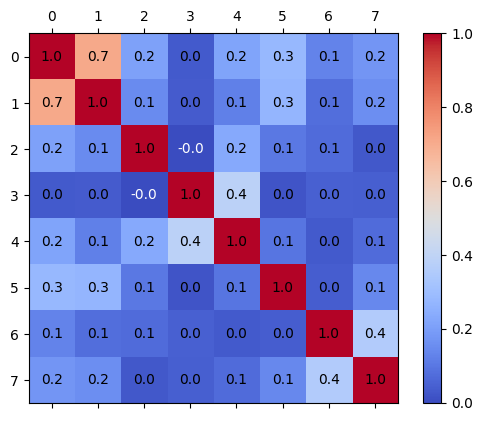

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def cossim(x):
    x = x / np.linalg.norm(x, axis=1)[:, None]
    return x @ x.T

sentence_embeddings = model.encode([
    "Coding is fun!",
    "Coding is boring.",
    "I love solar eclipses.",
    "Transformers are the key ingredient of LLMs",
    "Optimus Prime is my favorite Transformer",
    "Which is better: C or Python?",
    "Bach's Chaconne is a beast of a piece",
    "Mozart was a pretty good conductor"])

# Compute the cosine similarity of the embeddings
similarity_matrix = cossim(sentence_embeddings)

# Display the cosine similarity matrix
fig, ax = plt.subplots()
cax = ax.matshow(similarity_matrix, cmap='coolwarm')

fig.colorbar(cax)

for i in range(similarity_matrix.shape[0]):
    for j in range(similarity_matrix.shape[1]):
        ax.text(j, i, f'{similarity_matrix[i, j]:.1f}', va='center', ha='center', color='white' if similarity_matrix[i, j] < 0 else 'black')

plt.show()

In [ ]:
story = "On Monday, April 8, 2024, students and faculty at UTA witnessed a total solar eclipse."
prompt = "I woke up."

emb = model.encode([story, prompt])

print(cossim(emb)[0, 1])

# Add on to our story and compare again
part2 = model.encode(["Then I drove to campus."])
emb[1] += part2[0]

print(cossim(emb)[0, 1])

# Add on to our story and compare again
part3 = model.encode(["Everyone was outside waiting for the clouds to part."])
emb[1] += part3[0]

print(cossim(emb)[0, 1])

# Add on to our story and compare again
part4 = model.encode(["I put on the special glasses to keep my eyes safe from the UV."])
emb[1] += part4[0]

print(cossim(emb)[0, 1])

# Add on to our story and compare again
part5 = model.encode(["Finally the moon completely obscured the sun!"])
emb[1] += part5[0]

print(cossim(emb)[0, 1])


0.060831666
0.16293661
0.22590819
0.25106433
0.33809686


# Interested in learning more?

I highly recommend the following videos
- [Let's build the GPT tokenizer](https://www.youtube.com/watch?v=zduSFxRajkE) by Andrej Karpathy
- [But what is a GPT? Visual intro to transformers](https://www.youtube.com/watch?v=wjZofJX0v4M) by 3Blue1Brown

# References

- Raschka Sebastian, “Understanding Large Language Models.” https://magazine.sebastianraschka.com/p/understanding-large-language-models
- Morris, John X., Volodymyr Kuleshov, Vitaly Shmatikov, and Alexander M. Rush. “Text Embeddings Reveal (Almost) As Much As Text.” arXiv, October 10, 2023. https://doi.org/10.48550/arXiv.2310.06816.
- Vaswani, Ashish, Noam Shazeer, Niki Parmar, Jakob Uszkoreit, Llion Jones, Aidan N Gomez, Łukasz Kaiser, and Illia Polosukhin. “Attention Is All You Need,” 2017, 11.
- Liu, Peter J., Mohammad Saleh, Etienne Pot, Ben Goodrich, Ryan Sepassi, Lukasz Kaiser, and Noam Shazeer. “Generating Wikipedia by Summarizing Long Sequences.” arXiv, January 30, 2018. https://doi.org/10.48550/arXiv.1801.10198.
- Karpathy, Andrej. “The Unreasonable Effectiveness of Recurrent Neural Networks.” Accessed April 8, 2022. https://karpathy.github.io/2015/05/21/rnn-effectiveness/.
- Mikolov, Tomas, Kai Chen, Greg Corrado, and Jeffrey Dean. “Efficient Estimation of Word Representations in Vector Space.” arXiv, September 6, 2013. http://arxiv.org/abs/1301.3781.
